In [1]:
import matplotlib.pyplot as plt
import sys

sys.path.append('../src')
from sim import make_dataset
from slda import SLDA
from util import map_labels, show_dataset

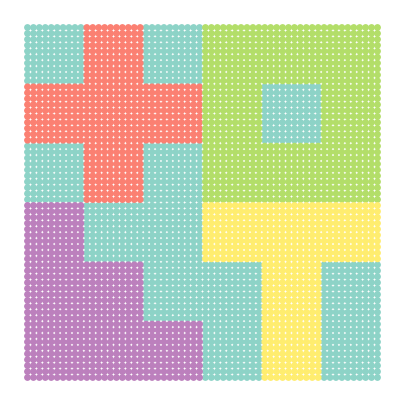

In [237]:
data, labels = make_dataset('polygons', 10, n_features=1000, wiggle=0., mix=0., return_tensor=True)
show_dataset(data, labels)

In [3]:
import numpy as np
from scipy.spatial.distance import cdist

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm

def activation(act='relu', **kwargs):
    if act == 'relu':
        return nn.ReLU(**kwargs)
    elif act == 'prelu':
        return nn.PReLU(**kwargs)
    elif act == 'softplus':
        return nn.Softplus(**kwargs)
    elif act == 'sigmoid':
        return nn.Sigmoid(**kwargs)
    elif act == 'tanh':
        return nn.Tanh(**kwargs)
    
    raise NotImplementedError(f'Activation "{act}" not supported.')

def layer(input_dim, output_dim, bias=True, batch_norm=False, act='relu', dropout=0.):
    yield nn.Linear(input_dim, output_dim, bias=bias)

    if batch_norm:
        yield nn.BatchNorm1d(output_dim)

    if act is not None:
        yield activation(act)

    if dropout > 0.:
        yield nn.Dropout(dropout)

def mlp(layers, bias=True, final_bias=True, batch_norm=False, final_norm=False, act='relu', final_act=None, dropout=0., final_drop=0.):
    n_layers = len(layers)
    net = []

    for i in range(1, n_layers):
        if i < n_layers - 1:
            yield from layer(layers[i - 1], layers[i], bias, batch_norm, act, dropout)
        else:
            yield from layer(layers[i - 1], layers[i], final_bias, final_norm, final_act, final_drop)

class MLP(nn.Module):
    def __init__(self, layers, bias=True, final_bias=True, batch_norm=False, final_norm=False, act='relu', final_act=None, dropout=0., final_drop=0.):
        super().__init__()

        self.net = nn.Sequential(*list(mlp(layers, bias, final_bias, batch_norm, final_norm, act, final_act, dropout, final_drop)))

    def forward(self, x):
        y = self.net(x)

        return y

class Encoder(nn.Module):
    def __init__(self, h_layers, g_layers, u_layers, f_layers):
        super().__init__()

        self.h_net = MLP(h_layers, act='prelu')
        self.g_net = MLP(g_layers, act='prelu')
        self.u_net = MLP(u_layers, act='prelu')
        self.f_net = MLP(f_layers, final_bias=False, act='prelu')

    def forward(self, data):
        h, u = self.h_net(data), self.u_net(data)
        U, K = u[1:].sum(0), 1
        H = torch.zeros((100, h.shape[-1]))
        H[0] = h[0]
        G = self.g_net(H[0])
        Gk = torch.zeros((100, G.shape[-1]))
        c = np.zeros(data.shape[0], dtype=np.int32)
        c[0] = 0
        q = torch.zeros(100)

        for n in range(1, data.shape[0]):
            U -= u[n]

            Gk[:K + 1] = G + self.g_net(H[:K + 1] + h[n]) - self.g_net(H[:K + 1])
            q[:K + 1] = self.f_net(torch.hstack([Gk[:K + 1], U[None].repeat(K + 1, 1)])).flatten()
            q = q / q.sum()
            c[n] = torch.multinomial(q[:K + 1], 1)

            if c[n] == K:
                K += 1

            G = G - self.g_net(H[c[n]]) + self.g_net(H[c[n]] + h[n])
            H[c[n]] = H[c[n]] + h[n]

        return c

In [288]:
H = 128
h_dim = 256
g_dim = 512

h_layers = [data.shape[-1], H, H, H, H, h_dim]
g_layers = [h_dim, H, H, H, H, g_dim]
u_layers = [data.shape[-1], H, H, H, H, g_dim]
f_layers = [2*g_dim, H, H, H, H, 1]

encoder = Encoder(h_layers, g_layers, u_layers, f_layers)
c = encoder(data)
c

array([ 0,  0,  1, ..., 55, 32, 14], dtype=int32)

In [239]:
c.max()

np.int32(84)

In [61]:
def featurize(data):
    sections = np.unique(data[:, 0])
    features = []

    for s in sections:
        section = data[data[:, 0] == s]
        proximity = cdist(section[:, 1:3], section[:, 1:3], 'euclidean')
        scale = np.sort(proximity, -1)[:, 1:17].mean(-1)
        # gaussian0 = np.exp(-proximity/(2*(.1*scale)**2))/np.sqrt(2*np.pi*(.1*scale)**2)
        gaussian1 = np.exp(-proximity**2/(2*(.5*scale)**2))/np.sqrt(2*np.pi*(.5*scale)**2)
        gaussian2 = np.exp(-proximity**2/(2*(1.*scale)**2))/np.sqrt(2*np.pi*(1.*scale)**2)
        features.append(np.hstack([gaussian1@section[:, 3:], gaussian2@section]))

    features = np.vstack(features)

    return features

def distribute(data, n_documents=None):
    sections = np.unique(data[:, 0])
    documents = []

    for s in sections:
        section = data[data[:, 0] == s]
        n_samples = section.shape[0]

        if n_documents is None:
            n_documents = n_samples//4

        idx = np.random.permutation(n_samples)[:n_documents]
        locations = section[idx, :3]
        proximity = cdist(locations[:, 1:], locations[:, 1:], 'sqeuclidean')
        scale = np.sort(proximity, -1)[:, 1:17].mean(-1)
        documents.append(np.hstack([locations, 4*scale[None].T]))

    documents = np.vstack(documents)

    return documents

SLDA: 100%|██████████| 100/100 [04:01<00:00,  2.41s/it]


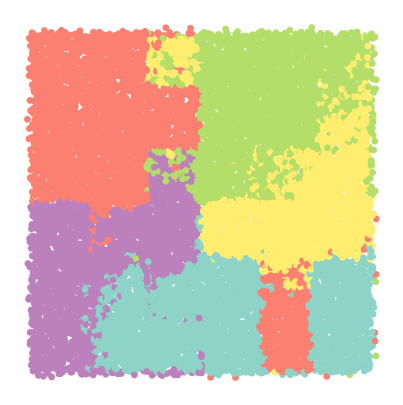

In [62]:
model = SLDA()
model._featurize = featurize
model._distribute = distribute
topics = model.fit_predict(data, n_steps=100, burn_in=75)
topics = map_labels(labels, topics)
show_dataset(data, topics)

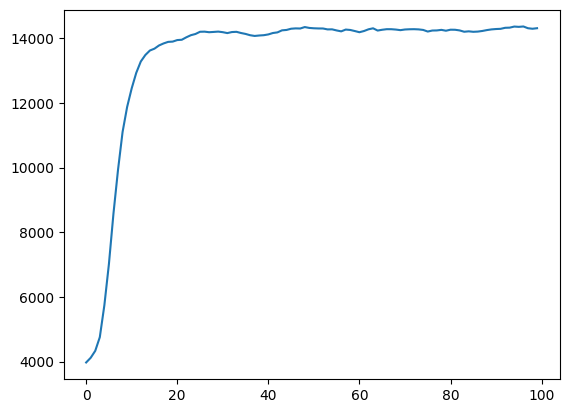

In [60]:
import numpy as np

x = np.arange(len(model.likelihood_log))
plt.plot(x, model.likelihood_log)
plt.show()